In [6]:
from google.colab import drive
drive.mount('/content/drive/')
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/shopping_behavior_updated.csv")

# Drop columns that won't be used in clustering
df = df.drop(['Customer ID', 'Promo Code Used', 'Item Purchased'], axis=1)

# Handle missing values
df.fillna(df.mean(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

# Encode categorical variables
label_cols = ['Gender', 'Category', 'Location', 'Size', 'Color', 'Season', 'Subscription Status', 'Shipping Type', 'Discount Applied', 'Payment Method']
for col in label_cols:
    if df[col].dtype == 'object':
        df[col] = LabelEncoder().fit_transform(df[col])

# Map 'Frequency of Purchases' to numerical values
frequency_mapping = {'Daily': 30, 'Weekly': 4, 'Fortnightly': 2, 'Monthly': 1, 'Rarely': 0.5}
df['Frequency of Purchases'] = df['Frequency of Purchases'].map(frequency_mapping)
df['Frequency of Purchases'].fillna(1, inplace=True)

# Scale numerical columns
num_cols = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases', 'Frequency of Purchases']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])




<ipython-input-7-5523140266c2>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Frequency of Purchases'].fillna(1, inplace=True)


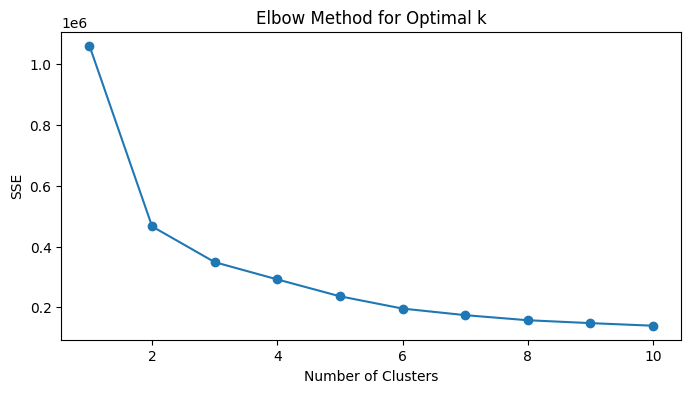

In [8]:
# K-means Clustering - Determine optimal k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    sse.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

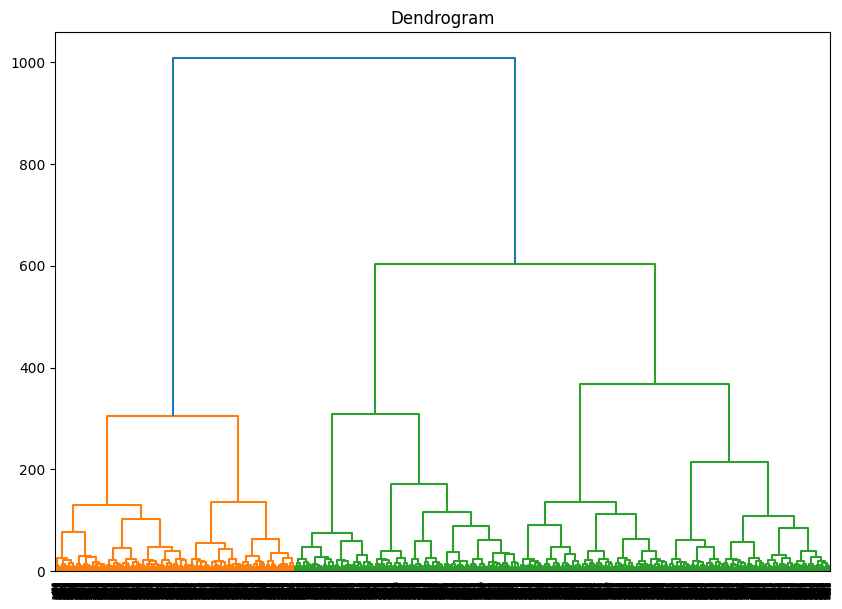

In [9]:
# Fit K-means with optimal k
optimal_k = 4  # Select based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(df)

# Hierarchical Clustering (Optional)
linked = linkage(df, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram')
plt.show()

Silhouette Score for k=4: 0.30346757385407336
Cluster Summary:
               Age    Gender  Category  Purchase Amount (USD)   Location  \
Cluster                                                                   
0       -0.003763  0.662921  1.035112               0.016118  40.721910   
1       -0.013702  0.684430  1.001665              -0.018317   7.114072   
2       -0.004831  0.674438  0.990841              -0.048835  22.432140   
3        0.031727  0.697201  0.988550               0.088008  38.371501   

             Size      Color    Season  Review Rating  Subscription Status  \
Cluster                                                                      
0        1.089888  18.397472  1.515449       0.029882             0.279494   
1        1.120733  12.011657  1.476270      -0.011265             0.263947   
2        1.127394  12.796003  1.494588       0.025825             0.272273   
3        1.134860   5.513995  1.494911      -0.049317             0.267176   

         Shippin

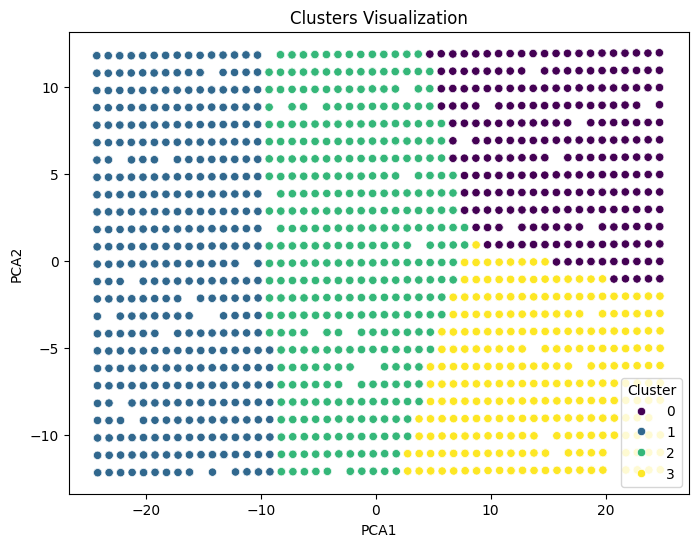

In [10]:
# Calculate silhouette score
silhouette_avg = silhouette_score(df.drop('Cluster', axis=1), df['Cluster'])
print(f'Silhouette Score for k={optimal_k}: {silhouette_avg}')

# Cluster analysis summary
cluster_summary = df.groupby('Cluster').mean()
print("Cluster Summary:\n", cluster_summary)

# PCA for 2D visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df.drop('Cluster', axis=1))
df['PCA1'] = pca_components[:, 0]
df['PCA2'] = pca_components[:, 1]

# Visualization of clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='viridis')
plt.title('Clusters Visualization')
plt.show()

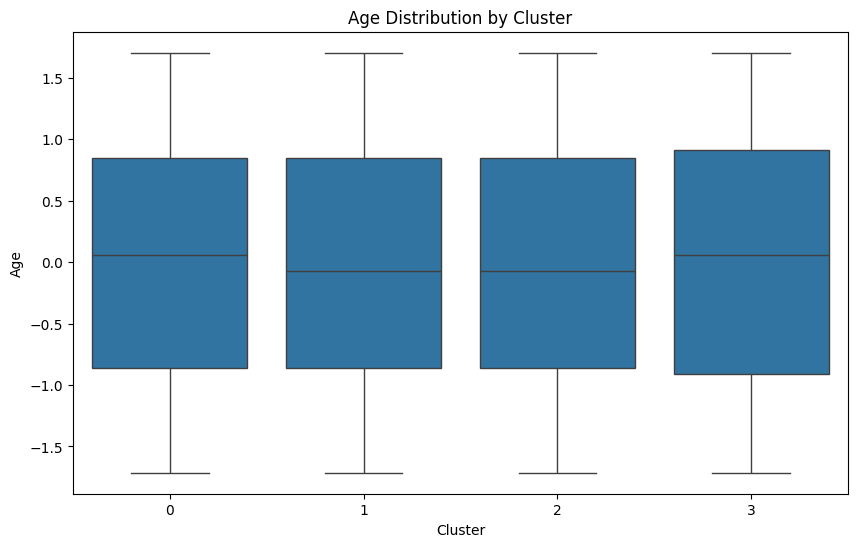

In [11]:
# Additional visualizations
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Age', data=df)
plt.title('Age Distribution by Cluster')
plt.show()

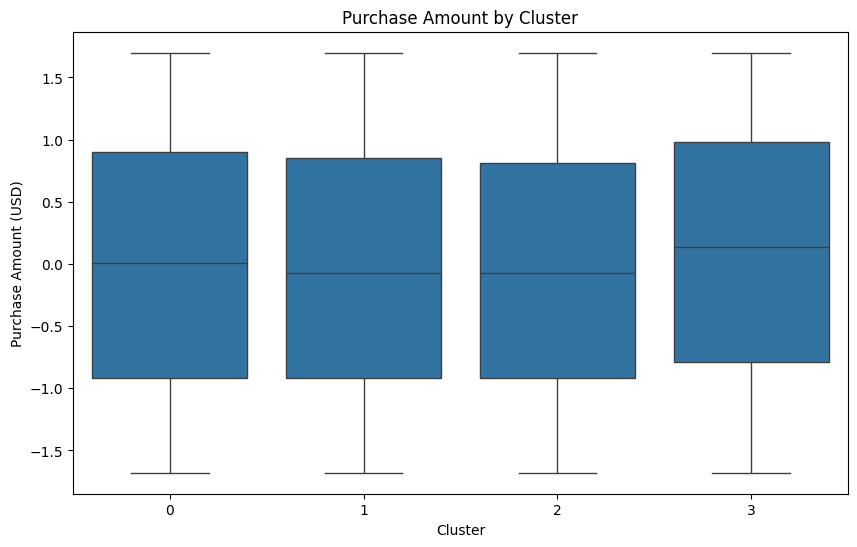

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Purchase Amount (USD)', data=df)
plt.title('Purchase Amount by Cluster')
plt.show()

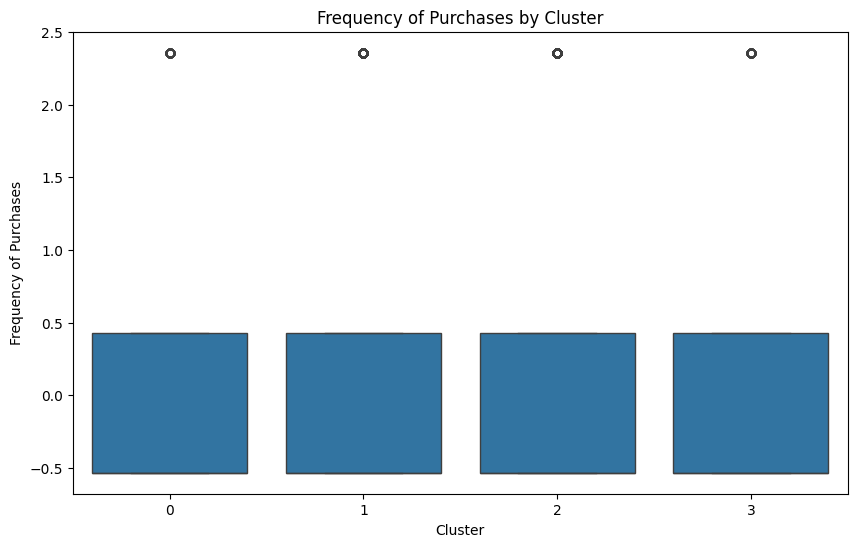

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Frequency of Purchases', data=df)
plt.title('Frequency of Purchases by Cluster')
plt.show()

In [14]:
print("Summary of customer segments:")
print(cluster_summary[['Age', 'Purchase Amount (USD)', 'Previous Purchases', 'Frequency of Purchases']])

Summary of customer segments:
              Age  Purchase Amount (USD)  Previous Purchases  \
Cluster                                                        
0       -0.003763               0.016118           -0.045434   
1       -0.013702              -0.018317            0.045410   
2       -0.004831              -0.048835            0.009096   
3        0.031727               0.088008           -0.042127   

         Frequency of Purchases  
Cluster                          
0                      0.007912  
1                      0.011347  
2                     -0.000691  
3                     -0.023449  
